In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statistics import mode
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
def kNearestNeighbor(trainData, testData, K=1):
  classColumnNum = trainData.shape[1]
  trainDataSize = len(trainData)
  testDataSize = len(testData)
  EuclideanDis = np.zeros((testDataSize, trainDataSize))
  for i in range(testDataSize):
    for j in range(trainDataSize):
      EuclideanDis[i,j] = np.linalg.norm(testData[i,0:classColumnNum-1]-trainData[j,0:classColumnNum-1])

  predicted = np.zeros(testDataSize)
  sample = np.zeros((2,trainDataSize))
  sample[1,:] = trainData[:,-1]
  for p in range(testDataSize):
    sample[0,:] = EuclideanDis[p,:]
    s_sample = sample[:, np.argsort(sample[0, :])]
    if K==1:
      predicted[p] = s_sample[1,p]
    else:
      predicted[p] = mode(s_sample[1,:K])
  
  return confusion_matrix(testData[:,-1].astype(float), predicted)

In [ ]:
def minimumMeanDistance(trainData, testData):
  classColumnNum = trainData.shape[1]
  trainDataSize = len(trainData)
  testDataSize = len(testData)
  allClasses = list(set(trainData[:,-1]))
  eachClassMeanEucDis = np.zeros(len(allClasses))
  EuclideanDis = np.zeros((len(allClasses), testDataSize, trainDataSize))
  predicted = np.zeros(testDataSize)
  for i in range(testDataSize):
    for j in range(trainDataSize):
      for k in allClasses:
        if trainData[j,-1] == k:
          EuclideanDis[k,i,j] = np.linalg.norm(testData[i,0:classColumnNum-1]-trainData[j,0:classColumnNum-1])
    for l in allClasses:
      eachClassMeanEucDis[l] = EuclideanDis[l,i].sum()/np.count_nonzero(EuclideanDis[l,i])
    predicted[i] = np.argmin(eachClassMeanEucDis)
  
  return confusion_matrix(testData[:,-1].astype(float), predicted)

In [ ]:
def gaussianDestributionBayes(trainData, testData, risk=False):
  allClasses = list(set(trainData[:,-1]))
  separatedByClass = {}
  for i in allClasses:
    separatedByClass[i] = trainData[trainData[:,-1] == i, :-1]

  allMeanSTD = {}
  for classLabel, instances in separatedByClass.items():
    mean_std = [(np.mean(attribute), np.std(attribute)) for attribute in zip(*instances)]
    allMeanSTD[classLabel] = mean_std

  if risk:
    Lambda = np.zeros(len(allClasses))
    Lambda[0] = 0.98
    Lambda[1] = 1.08

  predicted = np.zeros(len(testData))
  for i in range(len(testData)):
    probabilities = {}
    for classLabel, classAllMeanSTD in allMeanSTD.items():
      # probabilities[classLabel] = 1
      probabilities[classLabel] = len(separatedByClass[classLabel])/len(trainData)
      for j in range(len(classAllMeanSTD)):
        mean, stdev = classAllMeanSTD[j]
        exponent = math.exp(-(math.pow(testData[i,j]-mean,2)/(2*math.pow(stdev,2))))
        if risk:
          probabilities[classLabel] *= Lambda[classLabel] * (1/(math.sqrt(2*math.pi)*stdev))*exponent
        else:
          probabilities[classLabel] *= (1/(math.sqrt(2*math.pi)*stdev))*exponent
    bestLabel, bestProb = None, -1
    for classLabel, probability in probabilities.items():
      if bestLabel is None or probability > bestProb:
        bestProb = probability
        bestLabel = classLabel
    predicted[i] = bestLabel
    
  return confusion_matrix(testData[:,-1].astype(float), predicted)

In [ ]:
def supportVectorMachine(trainData, testData):
  W = np.zeros(np.size(trainData,1)-1)
  predicted = []
  for i,v in enumerate(trainData[:,-1]):
    if v==0:
      trainData[i,-1] = 1
    else:
      trainData[i,-1] = -1

  for i, val in enumerate(trainData[:,:-1]):
    val1 = np.dot(trainData[i,:-1], W)
    if (trainData[i,-1]*val1 < 1):
      W = W + ((trainData[i,-1]*trainData[i,:-1]) - (2*W))
    else:
      W = W + (-2*W)

  for i, val in enumerate(testData[:,:-1]):
    predicted.append(np.dot(testData[i,:-1], W))

  for i,v in enumerate(predicted):
    if np.sign(v) == 1:
      predicted[i] = 0
    else:
      predicted[i] = 1

  return confusion_matrix(testData[:,-1].astype(float), predicted)

In [ ]:
#Reading Data and Preprocessing
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset/'
df=pd.read_csv(data_dir + 'Cancer.csv', sep=',',header=None)
data = np.asarray(df)
data = np.delete(data, 0, 0)
data = np.delete(data, 0, 1)
data = np.delete(data, (data.shape[1]-1), 1)
data[:,[-1,0]] = data[:,[0,-1]]
data[:,:-1] = data[:,:-1].astype(np.float)
data[:,:-1] = normalize(data[:,:-1])

In [ ]:
#Principle Compnents Analysis
pca = PCA(n_components=20)
class_column = data.shape[1]
n_data = pca.fit_transform(data[:,0:class_column-2])
labels = data[:, -1:]
data_DR = np.append(n_data, labels, axis=1)
le = LabelEncoder()
le.fit(data_DR[:,-1])
data_DR[:,-1] = le.transform(data_DR[:,-1])
data_DR[:,-1] = data_DR[:,-1]

In [ ]:
#K-Fold Cross Validation
numOfMethods = 5
folds = 5
kf = KFold(n_splits=folds)
CM = np.zeros((numOfMethods,2,2))
TPR = np.zeros(numOfMethods)
FPR = np.zeros(numOfMethods)

for train, test in kf.split(data_DR):
  trainData = []
  testData = []
  for i in train:
    trainData.append(data_DR[i])
  for j in test:
    testData.append(data_DR[j]) 
  trainData = np.asarray(trainData)
  testData = np.asarray(testData)

  nameOfMethods = {0: [kNearestNeighbor(trainData, testData, K=1), 'KNN'],
                   1: [minimumMeanDistance(trainData, testData), 'Min Mean Dis'],
                   2: [gaussianDestributionBayes(trainData, testData), 'Gaussian Bayes'],
                   3: [gaussianDestributionBayes(trainData, testData, risk=True), 'Gaussian Bayes (Conditional Risk)'],
                   4: [supportVectorMachine(trainData, testData), 'SVM']}

  #Classification
  for z in range(0,numOfMethods):
    CM[z] += nameOfMethods[z][0]

for z in range(0,numOfMethods):
  print(z)
  CM[z] = np.round(CM[z]/folds)
  print('Confusion Matrix of ', nameOfMethods[z][1], ' Method')
  print(CM[z])
  print(nameOfMethods[z][1], 'Accuracy: ', (CM[z][0][0]+CM[z][1][1])/(sum(CM[z][0])+sum(CM[z][1])), '%')
  print('')
  TPR[z] = CM[z][0][0]/sum(CM[z][0])
  FPR[z] = CM[z][1][0]/sum(CM[z][1])

0
Confusion Matrix of  KNN  Method
[[65.  6.]
 [13. 29.]]
KNN Accuracy:  0.831858407079646 %

1
Confusion Matrix of  Min Mean Dis  Method
[[70.  1.]
 [ 9. 33.]]
Min Mean Dis Accuracy:  0.911504424778761 %

2
Confusion Matrix of  Gaussian Bayes  Method
[[61. 11.]
 [ 5. 37.]]
Gaussian Bayes Accuracy:  0.8596491228070176 %

3
Confusion Matrix of  Gaussian Bayes (Conditional Risk)  Method
[[42. 30.]
 [ 3. 39.]]
Gaussian Bayes (Conditional Risk) Accuracy:  0.7105263157894737 %

4
Confusion Matrix of  SVM  Method
[[49. 22.]
 [ 8. 34.]]
SVM Accuracy:  0.7345132743362832 %



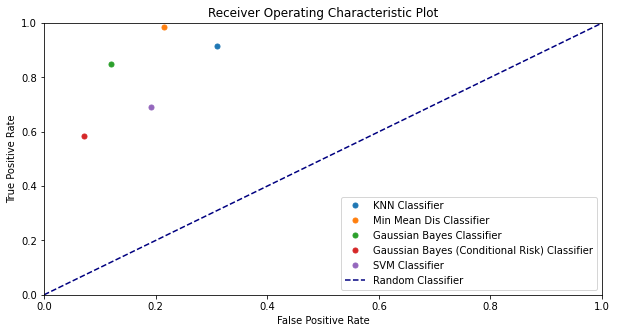

In [ ]:
#ROC Plot
plt.figure(figsize=[10, 5])
for z in range(0,numOfMethods):
  plt.plot(FPR[z]+0.001, TPR[z]+0.001, 'o' , markersize=5, label=(nameOfMethods[z][1] +  " Classifier"))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
plt.legend(loc="lower right")
plt.show()